## Classifica a qualidade do ar

- Esse projeto recebe os dados relativos a substâncias contidas no ar que são coletadas através de sensores químicos de qualidade do ar.
- Analisa e trata os dados submetendo a um algoritmo de clusterização de machine learning, definindo e marcando cada linha do arquivo com seu cluster mais adequado.
- Após a clusterização treina um modelo de classificação, em regressão logística de machine learning, fazendo a predição, em percentual, de qual a probabiliade da qualidade do ar, apresentado através dos componentes contidos no mesmo, de pertencer a um grupo ou a outro.

- Dados da qualidade do ar: https://archive.ics.uci.edu/dataset/360/air+quality

O conjunto de dados contém 9358 instâncias de respostas médias horárias de uma matriz de 5 sensores químicos de óxido de metal incorporados em um dispositivo multissensor químico de qualidade do ar. O dispositivo estava localizado no campo em uma área significativamente poluída, no nível da estrada, dentro de uma cidade italiana. Os dados foram registrados de março de 2004 a fevereiro de 2005 (um ano), representando as gravações mais longas disponíveis gratuitamente de respostas de dispositivos de sensores químicos de qualidade do ar implantados em campo. Concentrações médias horárias do Ground Truth para CO, hidrocarbonetos não metânicos, benzeno, óxidos de nitrogênio totais (NOx) e dióxido de nitrogênio (NO2) foram fornecidas por um analisador certificado de referência co-localizado. Evidências de sensibilidades cruzadas, bem como desvios de conceito e sensor estão presentes, conforme descrito em De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citação necessária), eventualmente afetando as capacidades de estimativa de concentração dos sensores. Valores ausentes são marcados com valor -200. Este conjunto de dados pode ser usado exclusivamente para fins de pesquisa. Fins comerciais são totalmente excluídos.



In [265]:
# importando bibliotecas
from sklearn.preprocessing import (
    OneHotEncoder, # transforma dados categóricos em colunas e valores binário 0-1
    StandardScaler, # faz a padronização dos dados para melhorar a normalidade
    MinMaxScaler, # transforma os valores dentro de uma escala entre 0 e 1 e melhora a normalidade
    PowerTransformer, # transforma os valores para melhorar a normalidade
)
from sklearn.compose import ColumnTransformer

from scipy.stats import skew 
from scipy.stats import kurtosis 
from fc import fc_retira_outliers as rto

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter('ignore')

In [266]:
# carregando arquivo de dados da qualidade do ar
df_quality = pd.read_csv('arquivos/AirQualityUCI.csv', sep=';')

In [267]:
# verificando o tamanho do arquivo conferindo a quantidade de linha(registros) e colunas(varáveis)
df_quality.shape

(9471, 17)

In [268]:
# reconhecendo as variáveis disponíveis
df_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [269]:
df_quality.head(3)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN


In [270]:
df_quality['CO(GT)'] = df_quality['CO(GT)'].replace(',','.', regex=True)
df_quality['C6H6(GT)'] = df_quality['C6H6(GT)'].replace(',','.', regex=True)
df_quality['T'] = df_quality['T'].replace(',','.', regex=True)
df_quality['RH'] = df_quality['RH'].replace(',','.', regex=True)
df_quality['AH'] = df_quality['AH'].replace(',','.', regex=True)

df_quality['CO(GT)'] = df_quality['CO(GT)'].replace(' ','', regex=True)
df_quality['C6H6(GT)'] = df_quality['C6H6(GT)'].replace(' ','', regex=True)
df_quality['T'] = df_quality['T'].replace(' ','', regex=True)
df_quality['RH'] = df_quality['RH'].replace(' ','', regex=True)
df_quality['AH'] = df_quality['AH'].replace(' ','', regex=True)

df_quality['Date'] = df_quality['Date'].replace(' ','', regex=True)
df_quality['Time'] = df_quality['Time'].replace(' ','', regex=True)

In [271]:
df_quality['Date'] = df_quality['Date'].astype('datetime64[ns]')
df_quality['CO(GT)'] = df_quality['CO(GT)'].astype(float)
df_quality['C6H6(GT)'] = df_quality['C6H6(GT)'].astype(float)
df_quality['T'] = df_quality['T'].astype(float)
df_quality['RH'] = df_quality['RH'].astype(float)
df_quality['AH'] = df_quality['AH'].astype(float)

In [272]:
df_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   float64       
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
 15  Unnamed: 15    0 non-

In [273]:
df_quality['dia_semana'] = df_quality['Date'].dt.day_of_week # 0 = segunda-feira

In [274]:
list(df_quality.columns)

['Date',
 'Time',
 'CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH',
 'Unnamed: 15',
 'Unnamed: 16',
 'dia_semana']

In [275]:
df_quality = df_quality[['Date',
 'Time',
 'CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH',
 'dia_semana']]

In [276]:
lista_nome = ['Date',
 'Time',
 'CO-mg/m3/hr',
 'CO/hr',
 'NMHC-micgr/m3/hr',
 'C6H6-micgr/m3/hr',
 'NMHC/hr',
 'NOx-ppb/hr',
 'NOx/hr',
 'NO2-micgr/m3/hr',
 'NO2/hr',
 '03/hr',
 'temperatura°C',
 'umidade_relativa',
 'umidade_absoluta',
 'dia_semana']

In [277]:
df_quality.columns = lista_nome

In [278]:
df_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              9357 non-null   datetime64[ns]
 1   Time              9357 non-null   object        
 2   CO-mg/m3/hr       9357 non-null   float64       
 3   CO/hr             9357 non-null   float64       
 4   NMHC-micgr/m3/hr  9357 non-null   float64       
 5   C6H6-micgr/m3/hr  9357 non-null   float64       
 6   NMHC/hr           9357 non-null   float64       
 7   NOx-ppb/hr        9357 non-null   float64       
 8   NOx/hr            9357 non-null   float64       
 9   NO2-micgr/m3/hr   9357 non-null   float64       
 10  NO2/hr            9357 non-null   float64       
 11  03/hr             9357 non-null   float64       
 12  temperatura°C     9357 non-null   float64       
 13  umidade_relativa  9357 non-null   float64       
 14  umidade_absoluta  9357 n

In [279]:
df_quality.isnull().sum()

Date                114
Time                114
CO-mg/m3/hr         114
CO/hr               114
NMHC-micgr/m3/hr    114
C6H6-micgr/m3/hr    114
NMHC/hr             114
NOx-ppb/hr          114
NOx/hr              114
NO2-micgr/m3/hr     114
NO2/hr              114
03/hr               114
temperatura°C       114
umidade_relativa    114
umidade_absoluta    114
dia_semana          114
dtype: int64

In [280]:
df_quality = df_quality.dropna()

In [281]:
df_quality.duplicated().sum()

0

In [282]:
df_quality = df_quality.drop_duplicates()

In [283]:
# checando mais uma vez a dimensão do dataframe
# temos um df com 9819 linhas(registros) e 45 colunas(campos - variáveis)

df_quality.shape

(9357, 16)

In [286]:
# chama função para retirar outliers, vamos passar mais de uma vez para reduzir os outliers
'''
i=0
while i != dfx.shape:
    i= dfx.shape
    dfx = rto.retira_outliers(dfx)
'''   

#df_quality = rto.retira_outliers(df_quality)

'\ni=0\nwhile i != dfx.shape:\n    i= dfx.shape\n    dfx = rto.retira_outliers(dfx)\n'

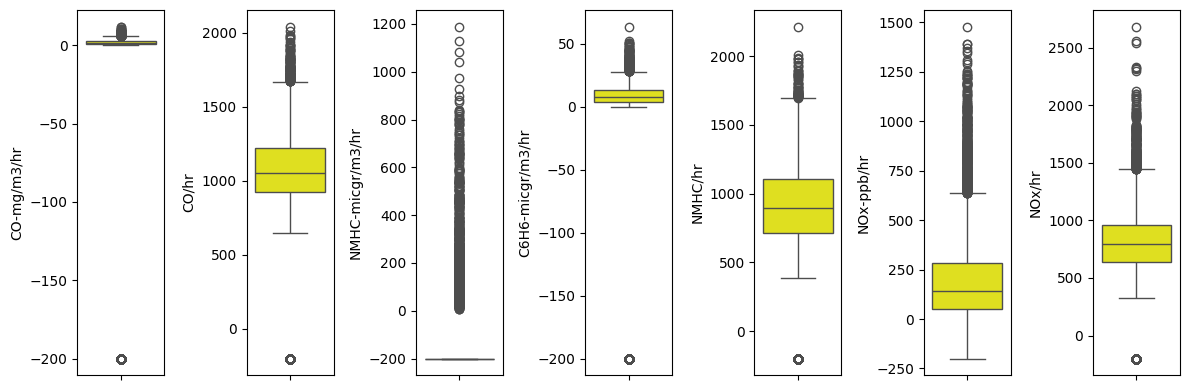

In [295]:
# visualizando boxplot para ver a distribuição nos quartis e a existência de outliers
# os outliers que sobraram não apresentam muita distorção, vamos mantê-los para não diminuir muito nossa
# base de dados
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(12, 4), tight_layout=True)

search_outliers = ['CO-mg/m3/hr',
               'CO/hr',
               'NMHC-micgr/m3/hr',
               'C6H6-micgr/m3/hr',
               'NMHC/hr',
               'NOx-ppb/hr',
               'NOx/hr',
               ]

for i, column in enumerate(search_outliers):
    sns.boxplot(y=column, data=df_quality, ax=axs[i], color='yellow')
plt.show()

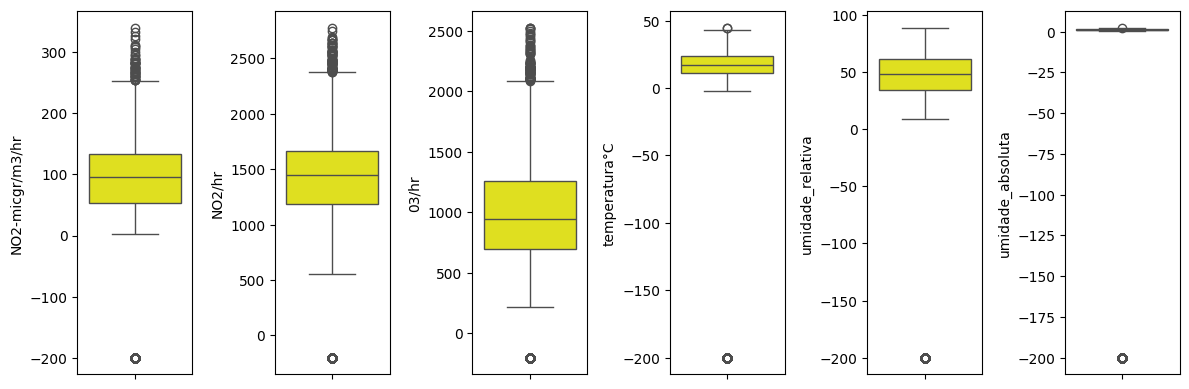

In [293]:
# visualizando boxplot para ver a distribuição nos quartis e a existência de outliers
# os outliers que sobraram não apresentam muita distorção, vamos mantê-los para não diminuir muito nossa
# base de dados
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(12, 4), tight_layout=True)

search_outliers = ['NO2-micgr/m3/hr',
               'NO2/hr',
               '03/hr',
               'temperatura°C',
               'umidade_relativa',
               'umidade_absoluta'
               ]

for i, column in enumerate(search_outliers):
    sns.boxplot(y=column, data=df_quality, ax=axs[i], color='yellow')
plt.show()

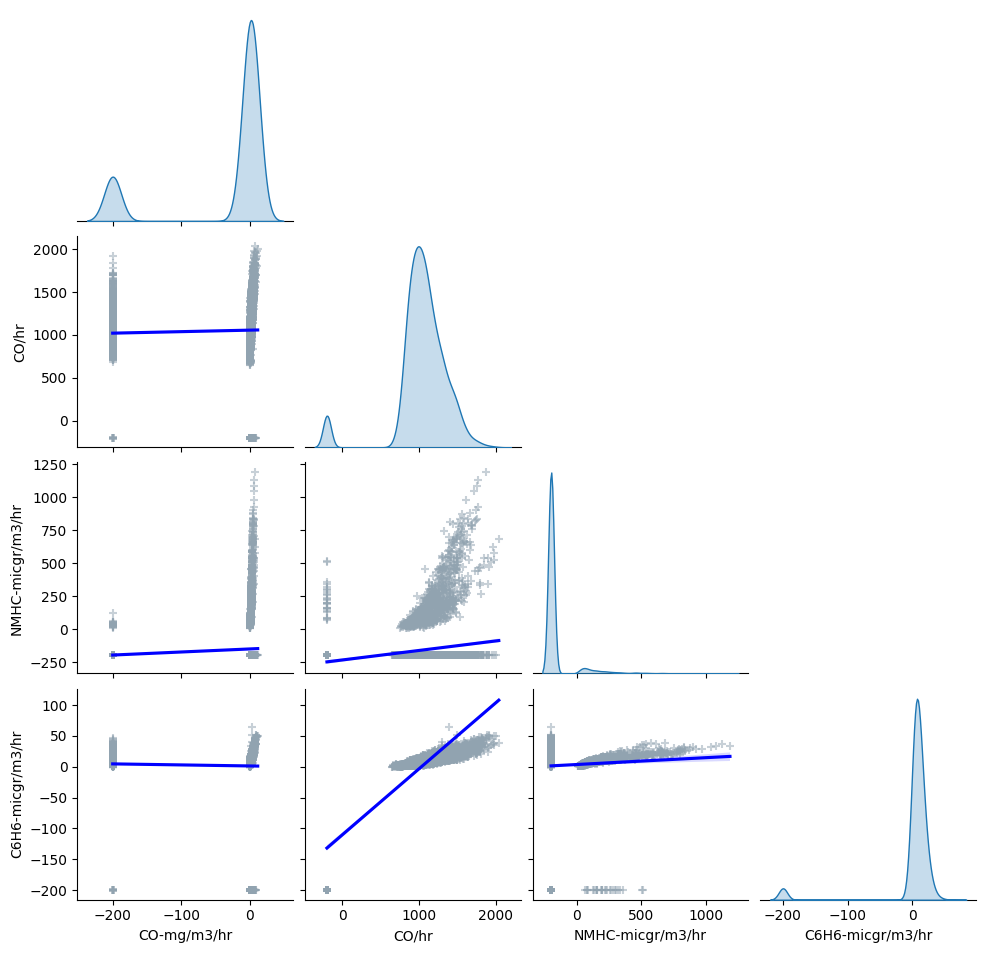

In [289]:
# verificando a distribuição dos dados
p= sns.pairplot(
   df_quality[['CO-mg/m3/hr',
               'CO/hr',
               'NMHC-micgr/m3/hr',
               'C6H6-micgr/m3/hr',
               ]],
                diag_kind="kde", corner=True, markers="+",
                plot_kws={'line_kws':{'color':'#0000ff'}, 
                           'scatter_kws': {'alpha': 0.5, 
                                           'color': '#91a3b0'}},
                kind='reg'
                );
p.fig.subplots_adjust(top=0.95)

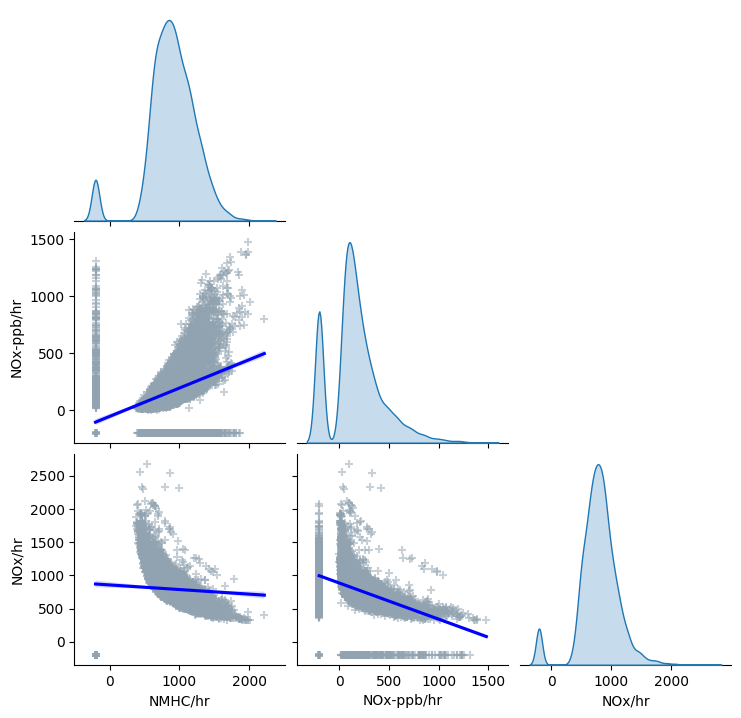

In [290]:
# verificando a distribuição dos dados
p= sns.pairplot(
   df_quality[['NMHC/hr',
               'NOx-ppb/hr',
               'NOx/hr',
               ]],
                diag_kind="kde", corner=True, markers="+",
                plot_kws={'line_kws':{'color':'#0000ff'}, 
                           'scatter_kws': {'alpha': 0.5, 
                                           'color': '#91a3b0'}},
                kind='reg'
                );
p.fig.subplots_adjust(top=0.95)

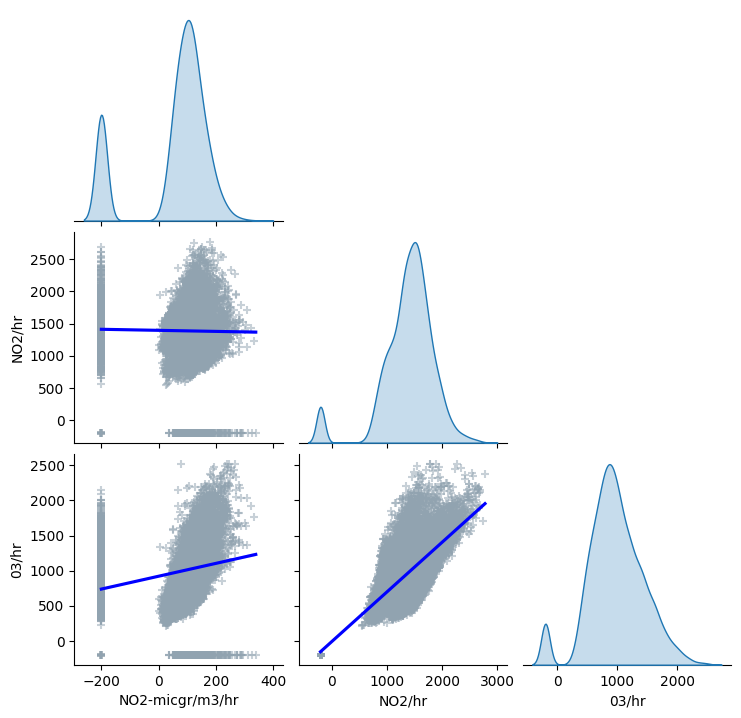

In [291]:
# verificando a distribuição dos dados
p= sns.pairplot(
   df_quality[['NO2-micgr/m3/hr',
               'NO2/hr',
               '03/hr',
               ]],
                diag_kind="kde", corner=True, markers="+",
                plot_kws={'line_kws':{'color':'#0000ff'}, 
                           'scatter_kws': {'alpha': 0.5, 
                                           'color': '#91a3b0'}},
                kind='reg'
                );
p.fig.subplots_adjust(top=0.95)

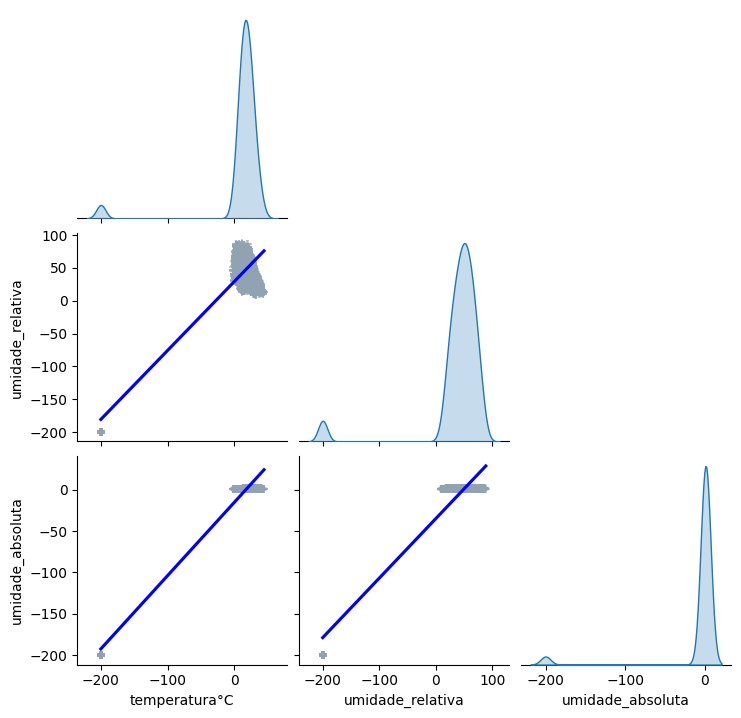

In [292]:
# verificando a distribuição dos dados
p= sns.pairplot(
   df_quality[['temperatura°C',
               'umidade_relativa',
               'umidade_absoluta'
               ]],
                diag_kind="kde", corner=True, markers="+",
                plot_kws={'line_kws':{'color':'#0000ff'}, 
                           'scatter_kws': {'alpha': 0.5, 
                                           'color': '#91a3b0'}},
                kind='reg'
                );
p.fig.subplots_adjust(top=0.95)